##### This requires that the Nontarget and KO files have identical line entries (i.e., each has PP_#### for KO and Nontarget)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adjustText import adjust_text

# Load the data files
Nontarget = pd.read_csv('Sept_NT.csv')  # Replace with your actual file names
target = pd.read_csv('Sept_T.csv')
name_df = pd.read_csv('proteomics_id_translator_240305.csv')  # Assuming a file with 'original' and 'locus' columns

In [2]:
# Step 1: Translate Measurement Type names to locus
translator_dict = {}
nontranslated = 0
for orig_label in Nontarget['Measurement Type']:
    matching_idx = name_df['original'].str.contains(orig_label, regex=False)
    if sum(matching_idx) == 1:
        translator_dict[orig_label] = name_df.loc[matching_idx, 'locus'].values[0]
    else:
        translator_dict[orig_label] = orig_label  # Keep the original name if no match
        nontranslated += 1
print(f"In total, N = {nontranslated}/{len(Nontarget['Measurement Type'])} proteins were not translated to locus names")

# Apply the translation to both files
Nontarget['Measurement Type'] = Nontarget['Measurement Type'].map(translator_dict)
target['Measurement Type'] = target['Measurement Type'].map(translator_dict)

In total, N = 1775/52075 proteins were not translated to locus names


In [5]:
# Initialize a DataFrame to store log2 and log10 values for all samples
log2_log10_results = pd.DataFrame()

# Step 2: Loop over unique sample names
sample_names = Nontarget['Line Name'].unique()

for sample in sample_names:
    # Filter data for the current sample
    Nontarget_sample = Nontarget[Nontarget['Line Name'] == sample]
    target_sample = target[target['Line Name'] == sample]

    # Filter for Counts_sum > 100,000
    Nontarget_sample = Nontarget_sample[Nontarget_sample['Value'] > 100000]
    target_sample = target_sample[target_sample['Value'] > 100000]

    # Step 3: Compute mean Counts_sum for each protein
    Nontarget_mean = Nontarget_sample.groupby('Measurement Type')['Value'].mean().reset_index()
    target_mean = target_sample.groupby('Measurement Type')['Value'].mean().reset_index()

    # Rename columns for clarity
    Nontarget_mean.rename(columns={'Value': 'Nontarget_abundance'}, inplace=True)
    target_mean.rename(columns={'Value': 'target_abundance'}, inplace=True)

    # Step 4: Merge the data on Measurement Type
    merged_data = pd.merge(Nontarget_mean, target_mean, on='Measurement Type', how='outer')  # Ensure all proteins are included

    # Step 5: Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['target_abundance'] / merged_data['Nontarget_abundance'])

    # Step 6: Compute p-values (assume replicates data exists for actual p-value calculation)
    Nontarget_reps = Nontarget_sample[['Measurement Type', 'Value']]
    target_reps = target_sample[['Measurement Type', 'Value']]

    p_values = []
    for protein in merged_data['Measurement Type']:
        group1 = Nontarget_reps[Nontarget_reps['Measurement Type'] == protein]['Value']
        group2 = target_reps[target_reps['Measurement Type'] == protein]['Value']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan  # Assign NaN if data is missing
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Step 7: Ensure consistent row alignment in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results['Locus'] = merged_data['Measurement Type']  # Start with the first set of loci
    else:
        log2_log10_results = pd.merge(
            log2_log10_results,
            merged_data[['Measurement Type', 'log2_change', 'log10_p_value']],
            left_on='Locus',
            right_on='Measurement Type',
            how='outer'
        ).drop(columns=['Measurement Type'])

    # Add current sample's log2 and log10 values as new columns
    log2_log10_results.rename(
        columns={'log2_change': f'{sample}_log2_change', 'log10_p_value': f'{sample}_log10_p_value'},
        inplace=True
    )

    # # Step 8: Create volcano plot for the current sample
    # fold_change = merged_data['log2_change']
    # p_values = merged_data['log10_p_value']
    # log_sig_thresh = 2

    # plt.figure(figsize=(6, 6))
    # plt.scatter(fold_change, p_values, s=15, alpha=0.25)  # Adjust marker size and transparency as needed
    # plt.title(f"Target/Nontarget ({sample})")  # Title reflects the sample name
    # plt.xlabel("Log2(Fold Change)")
    # plt.ylabel("Log10(P-Value)")
    # plt.grid(False)
    # plt.ylim(0,7.5)  # Adjust y-axis range if needed
    # plt.xlim(-7.5, 7.5)  # Adjust x-axis range if needed

    # # Threshold lines for fold change and p-values
    # plt.axvline(x=log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change > 2
    # plt.axvline(x=-log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change < -2
    # plt.axhline(y=-np.log10(0.01), color='g', linestyle='--', linewidth=1)  # P-value < 0.01

    # # Annotate points that meet specific conditions
    # texts = []
    # labels = merged_data['Measurement Type']  # Use translated locus names for annotation
    # for i, label in enumerate(labels):
    #     if (fold_change[i] < -log_sig_thresh and p_values[i] > -np.log10(0.01)) or (fold_change[i] > log_sig_thresh and p_values[i] > -np.log10(0.01)):  # Modify conditions as necessary
    #         text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
    #         texts.append(text)

    # # Adjust text annotations to avoid overlaps
    # if texts:
    #     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

    # # Show the plot
    # plt.show()

# Step 9: Save the log2 and log10 values to a CSV file
log2_log10_results.to_csv('log2_log10_values_by_sample.csv', index=False)
print("Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'")

C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\

Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'


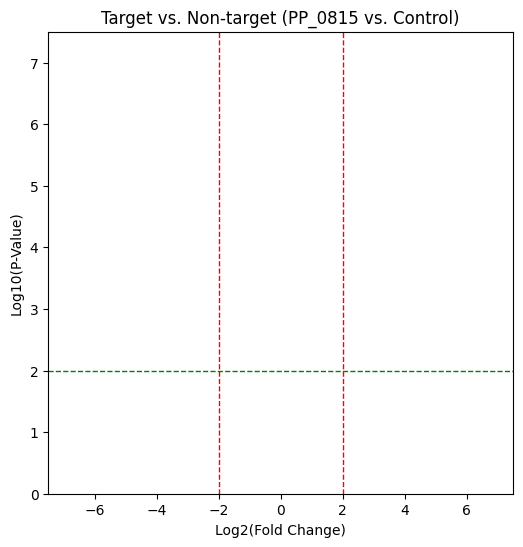

Log2 and Log10 values saved to 'log2_log10_values_PP_0815_vs_Control.csv'


In [4]:
# Filter for specific samples: Control (Non-target) and PP_0815 (Target)
Nontarget_sample = Nontarget[Nontarget['Line Name'] == 'Control']
target_sample = target[target['Line Name'] == 'PP_0815']

# Filter for Counts_sum > 100,000
Nontarget_sample = Nontarget_sample[Nontarget_sample['Value'] > 100000]
target_sample = target_sample[target_sample['Value'] > 100000]

# Compute mean Counts_sum for each protein
Nontarget_mean = Nontarget_sample.groupby('Measurement Type')['Value'].mean().reset_index()
target_mean = target_sample.groupby('Measurement Type')['Value'].mean().reset_index()

# Rename columns for clarity
Nontarget_mean.rename(columns={'Value': 'Nontarget_abundance'}, inplace=True)
target_mean.rename(columns={'Value': 'target_abundance'}, inplace=True)

# Merge the data on Measurement Type
merged_data = pd.merge(Nontarget_mean, target_mean, on='Measurement Type', how='outer')  # Ensure all proteins are included

# Calculate log2 fold change (fill missing values with NaN)
merged_data['log2_change'] = np.log2(merged_data['target_abundance'] / merged_data['Nontarget_abundance'])

# Compute p-values (assume replicates data exists for actual p-value calculation)
Nontarget_reps = Nontarget_sample[['Measurement Type', 'Value']]
target_reps = target_sample[['Measurement Type', 'Value']]

p_values = []
for protein in merged_data['Measurement Type']:
    group1 = Nontarget_reps[Nontarget_reps['Measurement Type'] == protein]['Value']
    group2 = target_reps[target_reps['Measurement Type'] == protein]['Value']
    if not group1.empty and not group2.empty:
        _, p_val = ttest_ind(group1, group2, equal_var=False)
    else:
        p_val = np.nan  # Assign NaN if data is missing
    p_values.append(p_val)

# Add p-values and log10 transformation
merged_data['p_value'] = p_values
merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

# Create volcano plot for the comparison
fold_change = merged_data['log2_change']
p_values = merged_data['log10_p_value']
log_sig_thresh = 2

plt.figure(figsize=(6, 6))
plt.scatter(fold_change, p_values, s=15, alpha=0.25)  # Adjust marker size and transparency as needed
plt.title("Target vs. Non-target (PP_0815 vs. Control)")  # Title reflects the comparison
plt.xlabel("Log2(Fold Change)")
plt.ylabel("Log10(P-Value)")
plt.grid(False)
plt.ylim(0, 7.5)  # Adjust y-axis range if needed
plt.xlim(-7.5, 7.5)  # Adjust x-axis range if needed

# Threshold lines for fold change and p-values
plt.axvline(x=log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change > 2
plt.axvline(x=-log_sig_thresh, color='r', linestyle='--', linewidth=1)  # Fold change < -2
plt.axhline(y=-np.log10(0.01), color='g', linestyle='--', linewidth=1)  # P-value < 0.01

# Annotate points that meet specific conditions
texts = []
labels = merged_data['Measurement Type']  # Use translated locus names for annotation
for i, label in enumerate(labels):
    if (fold_change[i] < -log_sig_thresh and p_values[i] > -np.log10(0.01)) or (fold_change[i] > log_sig_thresh and p_values[i] > -np.log10(0.01)):
        text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
        texts.append(text)

# Adjust text annotations to avoid overlaps
if texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

# Show the plot
plt.show()

# Save the merged data to a CSV file
merged_data.to_csv('log2_log10_values_PP_0815_vs_Control.csv', index=False)
print("Log2 and Log10 values saved to 'log2_log10_values_PP_0815_vs_Control.csv'")


In [6]:
# Initialize a DataFrame to store log2 and log10 values for all samples
log2_log10_results = pd.DataFrame()

# Step 2: Loop over unique sample names
sample_names = Nontarget['Line Name'].unique()

for sample in sample_names:
    # Filter data for the current sample
    Nontarget_sample = Nontarget[Nontarget['Line Name'] == sample]
    target_sample = target[target['Line Name'] == sample]

    # Filter for Counts_sum > 100,000
    Nontarget_sample = Nontarget_sample[Nontarget_sample['Value'] > 100000]
    target_sample = target_sample[target_sample['Value'] > 100000]

    # Step 3: Compute mean Counts_sum for each protein
    Nontarget_mean = Nontarget_sample.groupby('Measurement Type')['Value'].mean().reset_index()
    target_mean = target_sample.groupby('Measurement Type')['Value'].mean().reset_index()

    # Rename columns for clarity
    Nontarget_mean.rename(columns={'Value': 'Nontarget_abundance'}, inplace=True)
    target_mean.rename(columns={'Value': 'target_abundance'}, inplace=True)

    # Step 4: Merge the data on Measurement Type
    merged_data = pd.merge(Nontarget_mean, target_mean, on='Measurement Type', how='outer')  # Ensure all proteins are included

    # Step 5: Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['target_abundance'] / merged_data['Nontarget_abundance'])

    # Step 6: Compute p-values (assume replicates data exists for actual p-value calculation)
    Nontarget_reps = Nontarget_sample[['Measurement Type', 'Value']]
    target_reps = target_sample[['Measurement Type', 'Value']]

    p_values = []
    for protein in merged_data['Measurement Type']:
        group1 = Nontarget_reps[Nontarget_reps['Measurement Type'] == protein]['Value']
        group2 = target_reps[target_reps['Measurement Type'] == protein]['Value']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan  # Assign NaN if data is missing
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Step 7: Ensure consistent row alignment in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = merged_data[['Measurement Type']]  # Start with the first set of loci
    else:
        log2_log10_results = pd.merge(
            log2_log10_results,
            merged_data[['Measurement Type']],
            on='Measurement Type',
            how='outer'
        )

    # Add current sample's log2 and log10 values as new columns
    log2_log10_results = pd.merge(
        log2_log10_results,
        merged_data[['Measurement Type', 'log2_change', 'log10_p_value']],
        on='Measurement Type',
        how='outer'
    )

    log2_log10_results.rename(
        columns={'log2_change': f'{sample}_log2_change', 'log10_p_value': f'{sample}_log10_p_value'},
        inplace=True
    )

# Step 9: Save the log2 and log10 values to a CSV file
log2_log10_results.to_csv('log2_log10_values_by_sample.csv', index=False)
print("Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'")

C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\

Log2 and Log10 values saved to 'log2_log10_values_by_sample.csv'
